# 27. Kaggle完全ワークフロー - コンペティション攻略法 (Kaggle Complete Workflow)

## 概要
Kaggleコンペティションで上位入賞するための完全なワークフローを学びます。データ探索から特徴量エンジニアリング、モデル構築、アンサンブル、サブミットまでの全ステップを実践的に解説します。

## 学習目標
- Kaggleコンペの全体像を理解できる
- 効果的なEDAを実施できる
- 戦略的な特徴量エンジニアリングができる
- 適切な検証戦略を選択できる
- アンサンブルで性能を向上できる
- 実践的なKaggle戦略を身につける

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import lightgbm as lgb
import xgboost as xgb
from scipy import stats
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

## 1. Kaggleコンペティションの全体像

### Kaggleとは

**Kaggle**は、世界最大のデータサイエンスコンペティションプラットフォームです。

### コンペティションの流れ

```
1. データ理解・EDA (10-20%)
   ↓
2. ベースラインモデル構築 (5-10%)
   ↓
3. 特徴量エンジニアリング (30-40%)
   ↓
4. モデル構築・チューニング (20-30%)
   ↓
5. アンサンブル・スタッキング (10-20%)
   ↓
6. 最終サブミット・振り返り (5-10%)
```

### Kaggleのティア

1. **Novice**: 初心者（メダルなし）
2. **Contributor**: 貢献者（Discussion/Notebookで活躍）
3. **Expert**: 専門家（メダル獲得）
4. **Master**: 達人（金メダル獲得）
5. **Grandmaster**: 最高位（複数の金メダル + Top 10入賞）

### メダル獲得の基準

- 🥉 **Bronze**: Top 40%
- 🥈 **Silver**: Top 20%
- 🥇 **Gold**: Top 10%

### 成功のための心構え

1. **焦らない**: 最初は完走を目標に
2. **学ぶ**: Public Notebooksから学ぶ
3. **実験**: 多くのアイデアを試す
4. **記録**: 実験結果を記録する
5. **コミュニティ**: Discussionで情報交換
6. **検証**: Local CV と Public LB の相関を確認
7. **忍耐**: Shake upを恐れない

## 2. Phase 1: データ理解とEDA

### EDAの目的

1. データの構造と品質を理解する
2. 欠損値・外れ値を検出する
3. 特徴量とターゲットの関係を把握する
4. 仮説を立てる
5. 特徴量エンジニアリングのヒントを得る

### EDAチェックリスト

```python
# ✅ EDAチェックリスト

# 1. データの基本情報
# - サンプル数、特徴量数は？
# - データ型は適切か？
# - メモリ使用量は？

# 2. ターゲット変数
# - 分布は？（正規分布、歪み、外れ値）
# - 対数変換が必要か？
# - クラス不均衡はあるか？

# 3. 特徴量の分析
# - 欠損値の割合は？
# - 数値変数の分布は？
# - カテゴリカル変数のカーディナリティは？
# - 定数特徴量はあるか？

# 4. 相関分析
# - 特徴量間の相関は？
# - ターゲットとの相関は?
# - 多重共線性はあるか？

# 5. 時系列性
# - 時間的な傾向はあるか？
# - トレンド、季節性は？
# - データリークの可能性は？
```

In [2]:
# サンプルデータの生成（住宅価格予測を模擬）
np.random.seed(42)
n_samples = 2000

# 特徴量の生成
data = {
    'Id': range(1, n_samples + 1),
    'OverallQual': np.random.randint(1, 11, n_samples),  # 品質（1-10）
    'GrLivArea': np.random.normal(1500, 500, n_samples),  # 居住面積
    'GarageCars': np.random.choice([0, 1, 2, 3, 4], n_samples, p=[0.05, 0.15, 0.5, 0.25, 0.05]),
    'GarageArea': np.random.normal(500, 150, n_samples),  # ガレージ面積
    'TotalBsmtSF': np.random.normal(1000, 300, n_samples),  # 地下室面積
    'YearBuilt': np.random.randint(1900, 2020, n_samples),
    'YearRemodAdd': np.random.randint(1950, 2020, n_samples),
    'MSSubClass': np.random.choice([20, 30, 40, 50, 60, 70, 80, 90], n_samples),
    'Neighborhood': np.random.choice(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 
                                     'Mitchel', 'Somerst', 'NWAmes', 'OldTown', 
                                     'BrkSide', 'Sawyer', 'NridgHt'], n_samples),
}

df_train = pd.DataFrame(data)

# ターゲット変数（住宅価格）の生成
# 価格 = 品質×係数 + 面積×係数 + ガレージ×係数 + ... + ノイズ
price = (
    df_train['OverallQual'] * 20000 +
    df_train['GrLivArea'] * 100 +
    df_train['GarageCars'] * 15000 +
    df_train['GarageArea'] * 50 +
    df_train['TotalBsmtSF'] * 30 +
    (df_train['YearBuilt'] - 1900) * 300 +
    np.random.normal(0, 20000, n_samples)
)

df_train['SalePrice'] = np.maximum(price, 50000)  # 最低価格50000

# 意図的に欠損値を追加
df_train.loc[np.random.choice(df_train.index, 100), 'GarageArea'] = np.nan
df_train.loc[np.random.choice(df_train.index, 50), 'TotalBsmtSF'] = np.nan

print(f"データサイズ: {df_train.shape}")
print(f"\nデータの先頭:")
print(df_train.head(10))
print(f"\nデータ型:")
print(df_train.dtypes)
print(f"\n基本統計量:")
print(df_train.describe())

データサイズ: (2000, 11)

データの先頭:
   Id  OverallQual    GrLivArea  GarageCars  GarageArea  TotalBsmtSF  \
0   1            7   565.899800           0  709.555308  1132.540338   
1   2            4   512.931276           2  645.407268   920.111989   
2   3            8  2021.304418           3  191.833967  1160.641866   
3   4            5  1240.073304           3  852.963867  1284.540004   
4   5            7   675.458833           1  548.206448  1318.098421   
5   6           10  2022.867566           1  428.219255  1281.735046   
6   7            3  1584.562025           3  577.859334  1452.419094   
7   8            7  1625.785542           3  353.378804  1336.867637   
8   9            8  1904.769636           2  581.919253  1188.555374   
9  10            5   845.011421           2  380.975531   656.901760   

   YearBuilt  YearRemodAdd  MSSubClass Neighborhood      SalePrice  
0       1990          1979          70      Crawfor  262167.401618  
1       1961          1964          80   

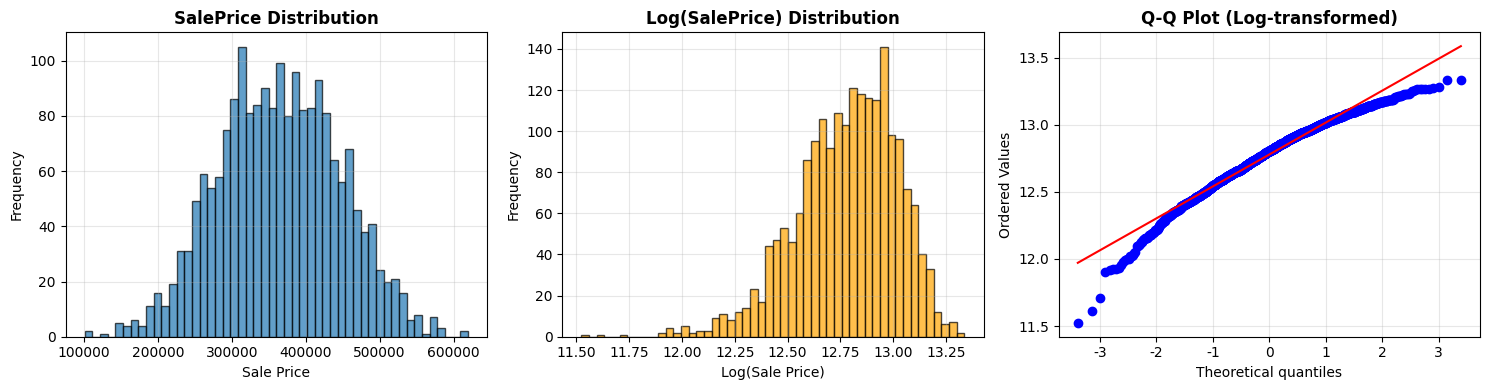


歪度:
- SalePrice: 0.011
- Log(SalePrice): -0.698

💡 ポイント:
- 対数変換により歪度が改善
- より正規分布に近づく
- RMSEよりRMSLEで評価する場合、対数変換が有効


In [3]:
# 1. ターゲット変数の分析
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ヒストグラム
axes[0].hist(df_train['SalePrice'], bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('SalePrice Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sale Price')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

# 対数変換後
axes[1].hist(np.log1p(df_train['SalePrice']), bins=50, alpha=0.7, 
             edgecolor='black', color='orange')
axes[1].set_title('Log(SalePrice) Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

# QQプロット
stats.probplot(np.log1p(df_train['SalePrice']), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Log-transformed)', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 歪度（skewness）の確認
skewness = df_train['SalePrice'].skew()
log_skewness = np.log1p(df_train['SalePrice']).skew()

print(f"\n歪度:")
print(f"- SalePrice: {skewness:.3f}")
print(f"- Log(SalePrice): {log_skewness:.3f}")
print(f"\n💡 ポイント:")
print("- 対数変換により歪度が改善")
print("- より正規分布に近づく")
print("- RMSEよりRMSLEで評価する場合、対数変換が有効")

欠損値の状況:
             Missing Count  Percentage
GarageArea              99        4.95
TotalBsmtSF             50        2.50


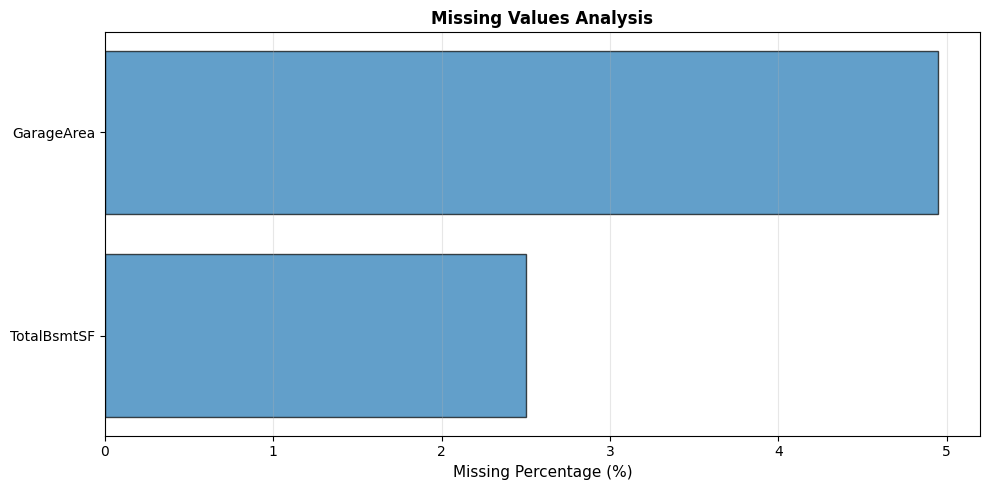


💡 欠損値の対処法:
- 欠損率 < 5%: 平均値/中央値で補完
- 欠損率 5-30%: モデルで予測して補完 or 欠損フラグを作成
- 欠損率 > 30%: 削除を検討
- カテゴリカル変数: 'Missing'という新カテゴリを作成


In [4]:
# 2. 欠損値の分析
missing = df_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(df_train)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})

print("欠損値の状況:")
print(missing_df)

# 可視化
if len(missing) > 0:
    plt.figure(figsize=(10, 5))
    plt.barh(range(len(missing)), missing_pct.values, alpha=0.7, edgecolor='black')
    plt.yticks(range(len(missing)), missing_pct.index)
    plt.xlabel('Missing Percentage (%)', fontsize=11)
    plt.title('Missing Values Analysis', fontsize=12, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

print("\n💡 欠損値の対処法:")
print("- 欠損率 < 5%: 平均値/中央値で補完")
print("- 欠損率 5-30%: モデルで予測して補完 or 欠損フラグを作成")
print("- 欠損率 > 30%: 削除を検討")
print("- カテゴリカル変数: 'Missing'という新カテゴリを作成")

SalePriceとの相関（上位10）:
SalePrice       1.000000
OverallQual     0.706720
GrLivArea       0.600277
GarageCars      0.186871
YearBuilt       0.117777
GarageArea      0.116688
TotalBsmtSF     0.095951
MSSubClass      0.024314
YearRemodAdd    0.015249
Name: SalePrice, dtype: float64


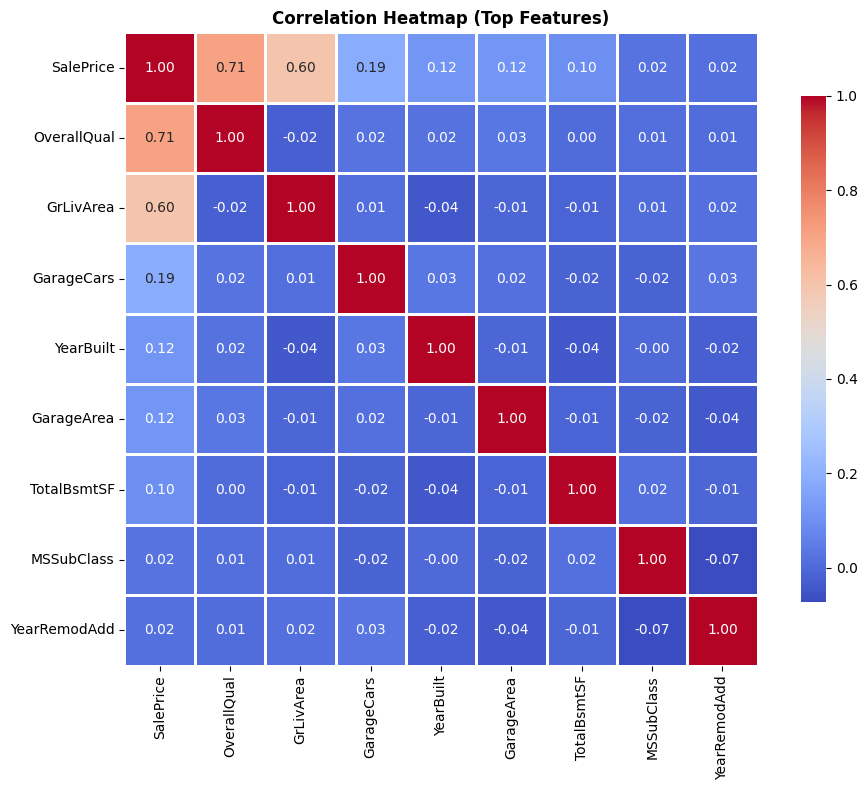


💡 相関分析のポイント:
- 相関 > 0.5: 強い正の相関 → 重要な特徴量候補
- 相関 < -0.5: 強い負の相関 → 注意が必要
- 特徴量間の相関 > 0.9: 多重共線性 → 片方を削除検討


In [5]:
# 3. 相関分析
# 数値変数のみ抽出
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('Id')  # IDは相関分析から除外

# 相関行列
corr_matrix = df_train[numeric_features].corr()

# ターゲットとの相関（上位10）
target_corr = corr_matrix['SalePrice'].sort_values(ascending=False)

print("SalePriceとの相関（上位10）:")
print(target_corr.head(10))

# ヒートマップ（主要な特徴量のみ）
top_features = target_corr.head(10).index.tolist()
corr_top = df_train[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_top, annot=True, fmt='.2f', cmap='coolwarm', 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (Top Features)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 相関分析のポイント:")
print("- 相関 > 0.5: 強い正の相関 → 重要な特徴量候補")
print("- 相関 < -0.5: 強い負の相関 → 注意が必要")
print("- 特徴量間の相関 > 0.9: 多重共線性 → 片方を削除検討")

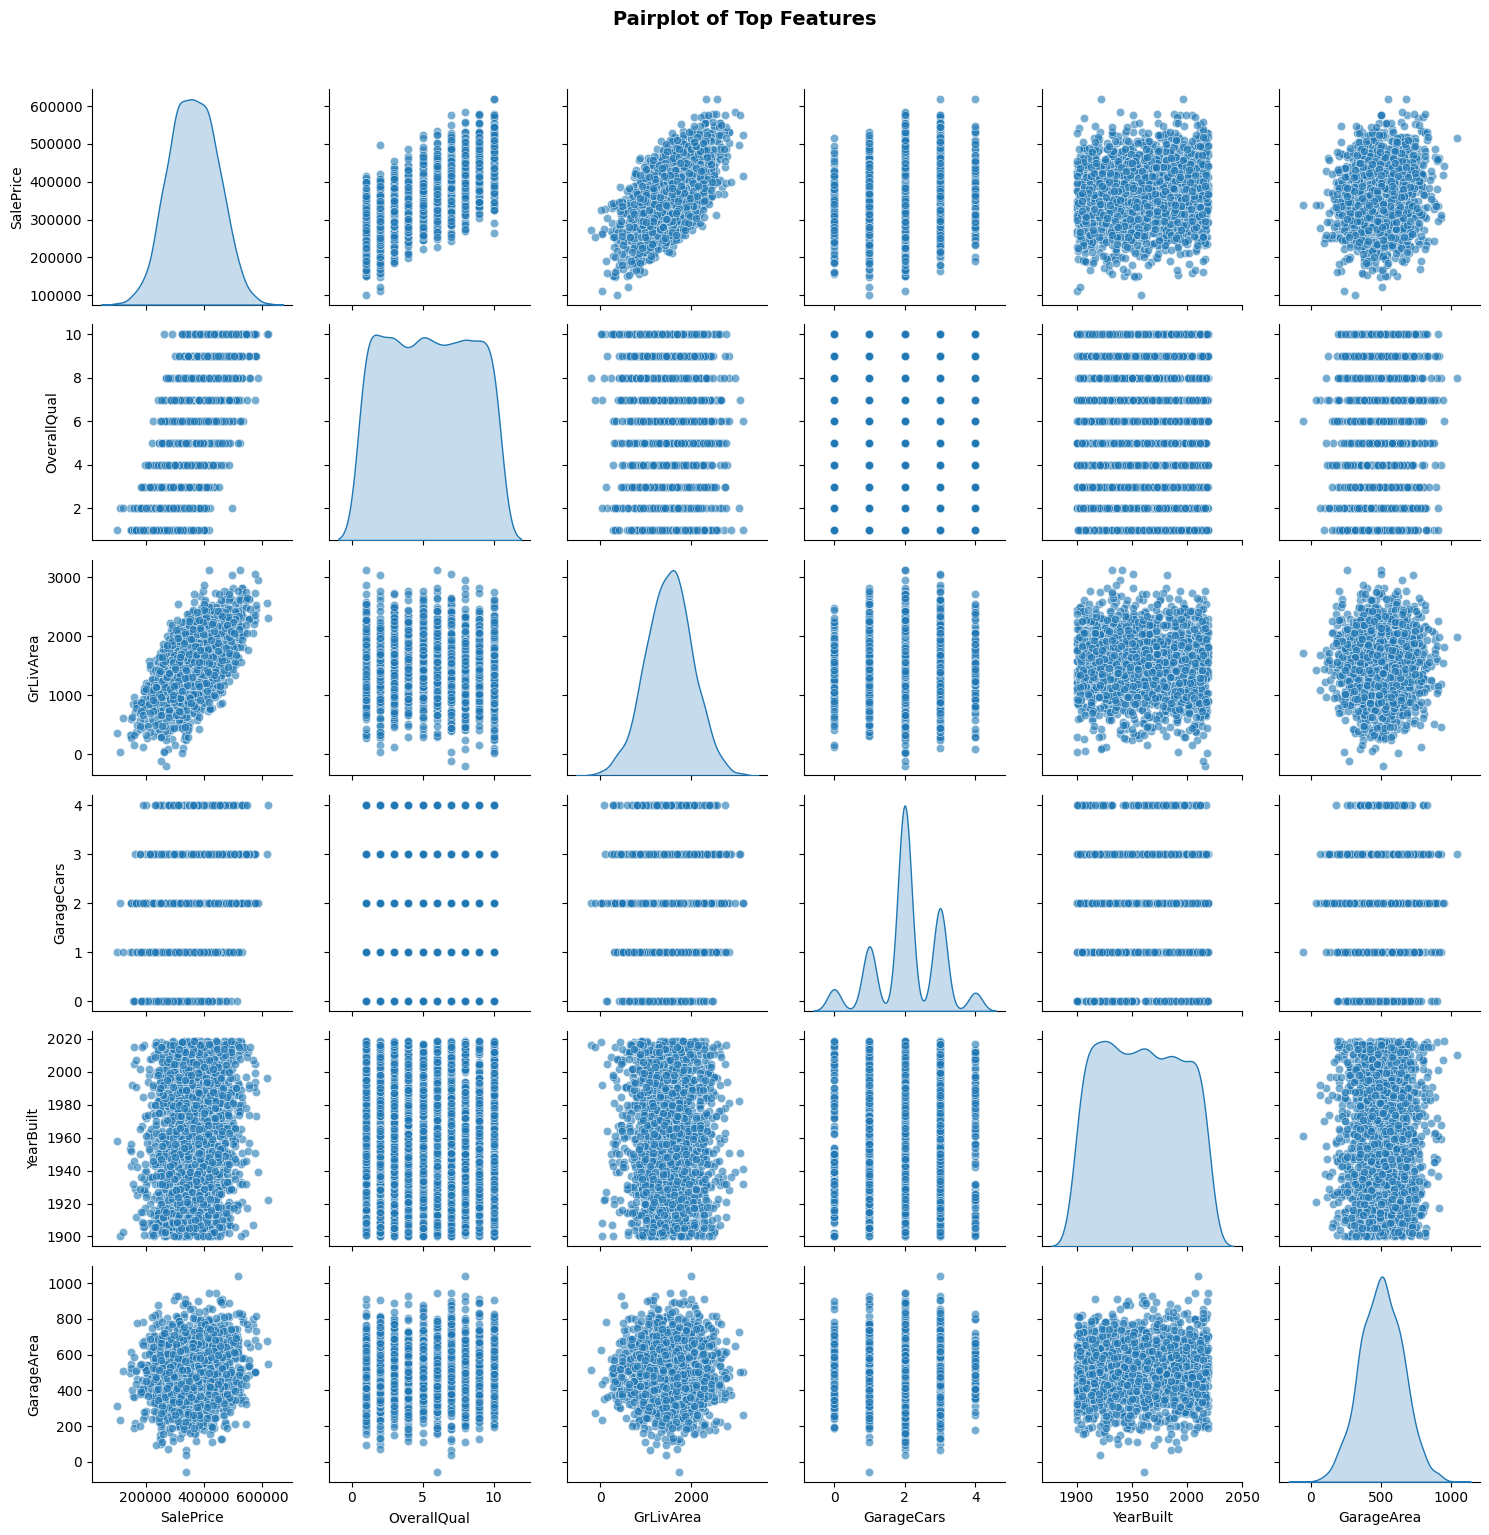


💡 ペアプロットから読み取れること:
- 線形関係の有無
- 外れ値の存在
- 非線形な関係性（多項式特徴量のヒント）


In [6]:
# 4. 散布図行列（ペアプロット）
# 上位5特徴量のみ
top5_features = target_corr.head(6).index.tolist()  # SalePriceを含む

sns.pairplot(df_train[top5_features], diag_kind='kde', 
             plot_kws={'alpha': 0.6}, height=2.5)
plt.suptitle('Pairplot of Top Features', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 ペアプロットから読み取れること:")
print("- 線形関係の有無")
print("- 外れ値の存在")
print("- 非線形な関係性（多項式特徴量のヒント）")

## 3. Phase 2: ベースラインモデル構築

### ベースラインの重要性

1. **基準点の設定**: 改善の度合いを測る基準
2. **サニティチェック**: データパイプラインの検証
3. **リーダーボード感覚**: Public LBとの相関確認
4. **早期フィードバック**: 問題の早期発見

### シンプルなベースラインから始める

```python
# 推奨順序
1. 単純な平均値予測
2. 線形回帰
3. Random Forest（デフォルトパラメータ）
4. LightGBM/XGBoost（デフォルトパラメータ）
```

In [7]:
# データ準備
# 欠損値を中央値で補完
df_model = df_train.copy()
for col in ['GarageArea', 'TotalBsmtSF']:
    df_model[col].fillna(df_model[col].median(), inplace=True)

# カテゴリカル変数のエンコーディング
df_model = pd.get_dummies(df_model, columns=['Neighborhood', 'MSSubClass'], drop_first=True)

# 特徴量とターゲットの分離
X = df_model.drop(['Id', 'SalePrice'], axis=1)
y = df_model['SalePrice']

# 対数変換（RMSLE対策）
y_log = np.log1p(y)

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"訓練データ: {X_train.shape}")
print(f"テストデータ: {X_test.shape}")
print(f"特徴量数: {X_train.shape[1]}")

訓練データ: (1600, 24)
テストデータ: (400, 24)
特徴量数: 24



ベースラインモデルの比較
           Model    RMSLE
        LightGBM 0.069467
Ridge Regression 0.077067
   Random Forest 0.078677
   Mean Baseline 0.241796


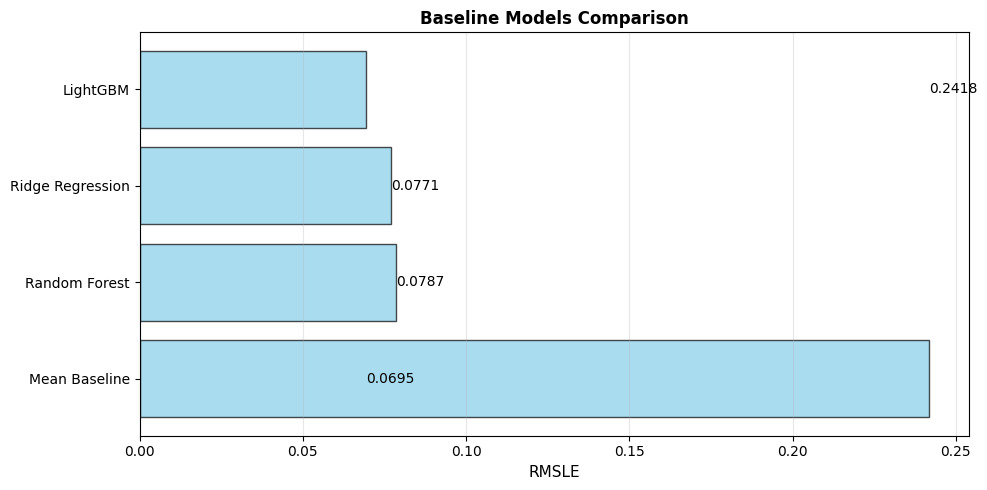


💡 ベースラインから学ぶこと:
- 最良モデル: LightGBM
- スコア: 0.0695
- これを基準に改善を目指す


In [8]:
# ベースラインモデルの比較
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred):
    """Root Mean Squared Logarithmic Error"""
    return np.sqrt(mean_squared_log_error(
        np.expm1(y_true), np.expm1(y_pred)
    ))

baseline_results = []

# 1. 平均値予測
y_pred_mean = np.full(len(y_test), y_train.mean())
rmsle_mean = rmsle(y_test, y_pred_mean)
baseline_results.append({'Model': 'Mean Baseline', 'RMSLE': rmsle_mean})

# 2. Ridge回帰
ridge = Ridge(alpha=10.0, random_state=42)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
rmsle_ridge = rmsle(y_test, y_pred_ridge)
baseline_results.append({'Model': 'Ridge Regression', 'RMSLE': rmsle_ridge})

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmsle_rf = rmsle(y_test, y_pred_rf)
baseline_results.append({'Model': 'Random Forest', 'RMSLE': rmsle_rf})

# 4. LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
rmsle_lgb = rmsle(y_test, y_pred_lgb)
baseline_results.append({'Model': 'LightGBM', 'RMSLE': rmsle_lgb})

# 結果の表示
baseline_df = pd.DataFrame(baseline_results).sort_values('RMSLE')

print("\n" + "=" * 60)
print("ベースラインモデルの比較")
print("=" * 60)
print(baseline_df.to_string(index=False))

# 可視化
plt.figure(figsize=(10, 5))
plt.barh(baseline_df['Model'], baseline_df['RMSLE'], 
         alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('RMSLE', fontsize=11)
plt.title('Baseline Models Comparison', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
for i, row in baseline_df.iterrows():
    plt.text(row['RMSLE'], row.name, f"{row['RMSLE']:.4f}",
            va='center', ha='left', fontsize=10)
plt.tight_layout()
plt.show()

print("\n💡 ベースラインから学ぶこと:")
print(f"- 最良モデル: {baseline_df.iloc[0]['Model']}")
print(f"- スコア: {baseline_df.iloc[0]['RMSLE']:.4f}")
print("- これを基準に改善を目指す")

## 4. Phase 3: 特徴量エンジニアリング

### 特徴量エンジニアリングの黄金律

**"特徴量が99%、モデルが1%"** - Andrew Ng

### 特徴量エンジニアリングの戦略

1. **ドメイン知識の活用**
   - 業界の常識を特徴量に
   - 専門家の意見を参考に

2. **既存特徴量の変換**
   - 対数変換、べき乗変換
   - スケーリング、正規化
   - Binning（ビニング）

3. **特徴量の組み合わせ**
   - 加減乗除
   - 多項式特徴量
   - 比率の計算

4. **集約特徴量**
   - グループ統計量（平均、標準偏差、最大、最小）
   - カウント特徴量
   - ランキング特徴量

5. **時系列特徴量**
   - ラグ特徴量
   - 移動平均
   - トレンド、季節性

In [9]:
# 特徴量エンジニアリングの実装
def create_features(df):
    """
    特徴量を作成
    """
    df_fe = df.copy()
    
    # 1. 年齢関連の特徴量
    df_fe['HouseAge'] = 2020 - df_fe['YearBuilt']
    df_fe['RemodAge'] = 2020 - df_fe['YearRemodAdd']
    df_fe['IsRemodeled'] = (df_fe['YearRemodAdd'] != df_fe['YearBuilt']).astype(int)
    
    # 2. 面積関連の特徴量
    df_fe['TotalSF'] = df_fe['GrLivArea'] + df_fe['TotalBsmtSF']
    df_fe['AreaPerRoom'] = df_fe['GrLivArea'] / (df_fe['OverallQual'] + 1)  # 部屋数の代理
    
    # 3. ガレージ関連
    df_fe['HasGarage'] = (df_fe['GarageCars'] > 0).astype(int)
    df_fe['GarageAreaPerCar'] = df_fe['GarageArea'] / (df_fe['GarageCars'] + 1)
    
    # 4. 品質関連
    df_fe['QualTimesArea'] = df_fe['OverallQual'] * df_fe['GrLivArea']
    df_fe['QualSquared'] = df_fe['OverallQual'] ** 2
    
    # 5. 比率特徴量
    df_fe['BsmtRatio'] = df_fe['TotalBsmtSF'] / (df_fe['GrLivArea'] + 1)
    df_fe['GarageRatio'] = df_fe['GarageArea'] / (df_fe['GrLivArea'] + 1)
    
    return df_fe

# 特徴量エンジニアリングを適用
df_enhanced = create_features(df_model)

print(f"元の特徴量数: {df_model.shape[1]}")
print(f"拡張後の特徴量数: {df_enhanced.shape[1]}")
print(f"追加された特徴量: {df_enhanced.shape[1] - df_model.shape[1]}")

# 新しい特徴量のリスト
new_features = set(df_enhanced.columns) - set(df_model.columns)
print(f"\n新しい特徴量:")
for feat in sorted(new_features):
    print(f"  - {feat}")

元の特徴量数: 26
拡張後の特徴量数: 37
追加された特徴量: 11

新しい特徴量:
  - AreaPerRoom
  - BsmtRatio
  - GarageAreaPerCar
  - GarageRatio
  - HasGarage
  - HouseAge
  - IsRemodeled
  - QualSquared
  - QualTimesArea
  - RemodAge
  - TotalSF


In [10]:
# 拡張特徴量での学習
X_enhanced = df_enhanced.drop(['Id', 'SalePrice'], axis=1, errors='ignore')

# 欠損値を補完
X_enhanced = X_enhanced.fillna(X_enhanced.median())

# データ分割
X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(
    X_enhanced, y_log, test_size=0.2, random_state=42
)

# LightGBMで再学習
lgb_enhanced = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    verbose=-1
)

lgb_enhanced.fit(X_train_enh, y_train_enh)
y_pred_enhanced = lgb_enhanced.predict(X_test_enh)
rmsle_enhanced = rmsle(y_test_enh, y_pred_enhanced)

print("\n" + "=" * 60)
print("特徴量エンジニアリングの効果")
print("=" * 60)
print(f"ベースライン（LightGBM）: {rmsle_lgb:.4f}")
print(f"拡張特徴量（LightGBM）:   {rmsle_enhanced:.4f}")
print(f"改善: {rmsle_lgb - rmsle_enhanced:.4f} ({(rmsle_lgb - rmsle_enhanced)/rmsle_lgb*100:.2f}%)")

print("\n💡 特徴量エンジニアリングの効果:")
print("- モデルの性能が向上")
print("- ドメイン知識の活用が鍵")
print("- 地道な実験が重要")


特徴量エンジニアリングの効果
ベースライン（LightGBM）: 0.0695
拡張特徴量（LightGBM）:   0.0686
改善: 0.0009 (1.30%)

💡 特徴量エンジニアリングの効果:
- モデルの性能が向上
- ドメイン知識の活用が鍵
- 地道な実験が重要


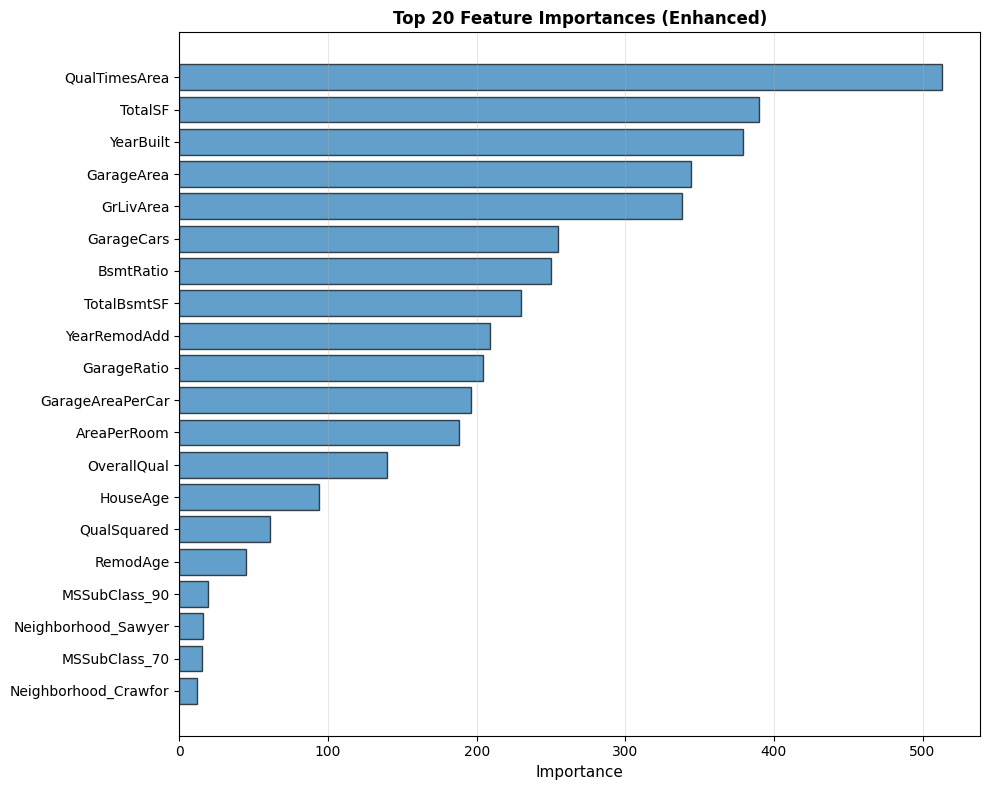


トップ20に入った新特徴量: 9個

新特徴量:
  - QualTimesArea
  - TotalSF
  - BsmtRatio
  - GarageRatio
  - GarageAreaPerCar
  - AreaPerRoom
  - HouseAge
  - QualSquared
  - RemodAge


In [11]:
# 特徴量重要度の確認
feature_importance = pd.DataFrame({
    'feature': X_enhanced.columns,
    'importance': lgb_enhanced.feature_importances_
}).sort_values('importance', ascending=False)

# 上位20特徴量を可視化
top20 = feature_importance.head(20)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top20)), top20['importance'].values, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top20)), top20['feature'].values)
plt.xlabel('Importance', fontsize=11)
plt.title('Top 20 Feature Importances (Enhanced)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 新特徴量がトップ20に入っているか確認
new_in_top20 = top20['feature'].isin(new_features)
print(f"\nトップ20に入った新特徴量: {new_in_top20.sum()}個")
if new_in_top20.sum() > 0:
    print("\n新特徴量:")
    for feat in top20[new_in_top20]['feature'].values:
        print(f"  - {feat}")

## 5. Phase 4: 検証戦略

### なぜ検証が重要か

- **過学習の検出**: テストデータでの性能を推定
- **モデル選択**: 最良のモデル・パラメータを選択
- **LB相関**: Local CVとPublic LBの相関を確認

### 検証戦略の種類

1. **Hold-out Validation**
   - シンプル、高速
   - データが少ない場合は不安定

2. **K-Fold Cross Validation**
   - より安定した評価
   - 計算コストが高い
   - K=5 or 10が一般的

3. **Stratified K-Fold**
   - クラス不均衡に対応
   - 分類問題で推奨

4. **Group K-Fold**
   - グループ構造がある場合
   - 例: 同一人物のデータをまとめる

5. **Time Series Split**
   - 時系列データ専用
   - 未来を予測する設定

5-Fold Cross Validation（LightGBM）


Fold 1: RMSLE = 0.0681


Fold 2: RMSLE = 0.0645


Fold 3: RMSLE = 0.0703


Fold 4: RMSLE = 0.0635


Fold 5: RMSLE = 0.0701

Mean RMSLE: 0.0673 ± 0.0028


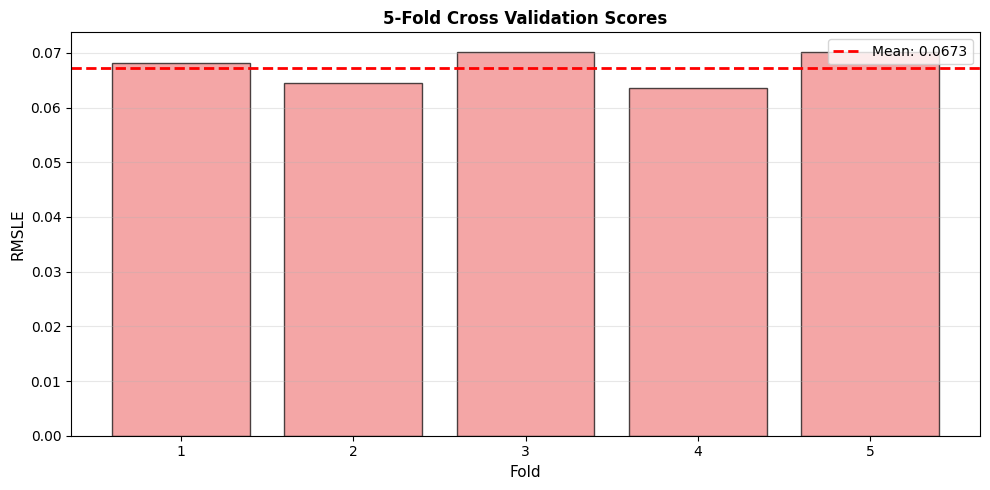


💡 CVのポイント:
- Fold間のばらつきが小さい → 安定したモデル
- ばらつきが大きい → データの偏りやランダム性
- Local CVとPublic LBの相関を確認することが重要


In [12]:
# K-Fold Cross Validationの実装
from sklearn.model_selection import KFold

def cv_score(model, X, y, n_splits=5):
    """
    K-Fold CVでスコアを計算
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X), 1):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # モデルの学習
        model.fit(X_fold_train, y_fold_train)
        
        # 予測
        y_pred = model.predict(X_fold_val)
        
        # 評価
        fold_score = rmsle(y_fold_val, y_pred)
        scores.append(fold_score)
        
        print(f"Fold {fold}: RMSLE = {fold_score:.4f}")
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"\nMean RMSLE: {mean_score:.4f} ± {std_score:.4f}")
    
    return mean_score, std_score, scores

# LightGBMで5-Fold CV
print("=" * 60)
print("5-Fold Cross Validation（LightGBM）")
print("=" * 60)

lgb_cv = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    random_state=42,
    verbose=-1
)

mean_cv, std_cv, fold_scores = cv_score(lgb_cv, X_enhanced, y_log, n_splits=5)

# Fold別のスコアを可視化
plt.figure(figsize=(10, 5))
plt.bar(range(1, 6), fold_scores, alpha=0.7, edgecolor='black', color='lightcoral')
plt.axhline(mean_cv, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_cv:.4f}')
plt.xlabel('Fold', fontsize=11)
plt.ylabel('RMSLE', fontsize=11)
plt.title('5-Fold Cross Validation Scores', fontsize=12, fontweight='bold')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 CVのポイント:")
print("- Fold間のばらつきが小さい → 安定したモデル")
print("- ばらつきが大きい → データの偏りやランダム性")
print("- Local CVとPublic LBの相関を確認することが重要")

## 6. Phase 5: アンサンブル

### アンサンブルの種類

1. **Averaging / Weighted Averaging**
   - 複数モデルの予測を平均
   - 重み付け平均で調整

2. **Blending**
   - Hold-outデータでメタモデルを学習
   - シンプルで高速

3. **Stacking**
   - Out-of-Fold予測でメタモデルを学習
   - より高度、データリークを防ぐ

### アンサンブルのコツ

- **多様性**: 異なるアルゴリズムを組み合わせる
- **相関**: 予測の相関が低いモデルを選ぶ
- **強モデル**: 単体性能が高いモデルを使う

In [13]:
# 複数モデルの学習
models = {}

# LightGBM
models['lgb'] = lgb.LGBMRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=6,
    random_state=42, verbose=-1
)

# XGBoost
models['xgb'] = xgb.XGBRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=6,
    random_state=42, eval_metric='rmse'
)

# Random Forest
models['rf'] = RandomForestRegressor(
    n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
)

# Ridge
models['ridge'] = Ridge(alpha=10.0, random_state=42)

# 各モデルの学習と予測
predictions = {}
model_scores = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_enh, y_train_enh)
    y_pred = model.predict(X_test_enh)
    predictions[name] = y_pred
    
    score = rmsle(y_test_enh, y_pred)
    model_scores.append({'Model': name, 'RMSLE': score})
    print(f"{name} RMSLE: {score:.4f}")

# モデルスコアの表示
scores_df = pd.DataFrame(model_scores).sort_values('RMSLE')
print("\n" + "=" * 60)
print("個別モデルの性能")
print("=" * 60)
print(scores_df.to_string(index=False))


Training lgb...


lgb RMSLE: 0.0690

Training xgb...


xgb RMSLE: 0.0733

Training rf...


rf RMSLE: 0.0779

Training ridge...
ridge RMSLE: 0.0688

個別モデルの性能
Model    RMSLE
ridge 0.068830
  lgb 0.069038
  xgb 0.073263
   rf 0.077866



アンサンブル結果
Simple Average: 0.0684

重み:
  lgb: 0.2610
  xgb: 0.2459
  rf: 0.2314
  ridge: 0.2618

Weighted Average: 0.0683

アンサンブル比較
           Method    RMSLE
Best Single Model 0.068830
   Simple Average 0.068441
 Weighted Average 0.068258


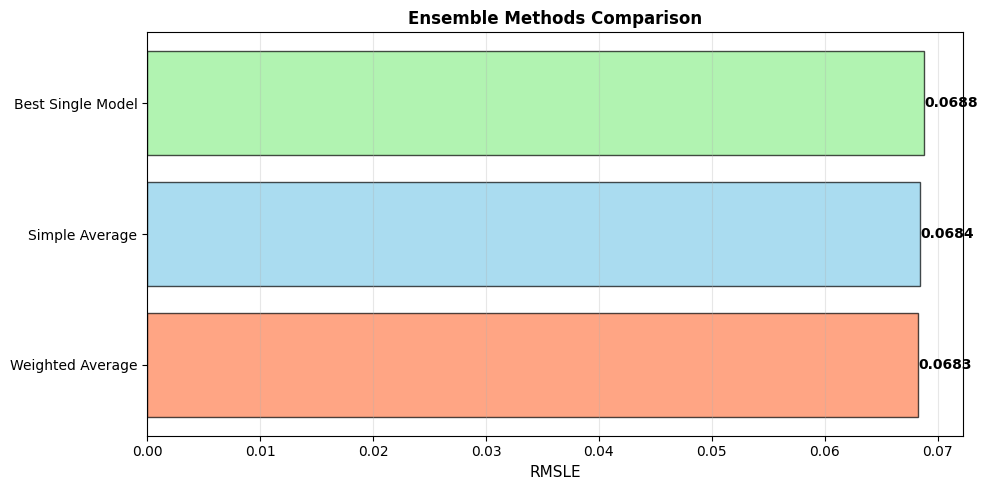


💡 アンサンブルの効果:
- 単一モデルより安定
- 多様なモデルを組み合わせることで改善
- Kaggleの上位解法では必須


In [14]:
# 1. シンプルな平均アンサンブル
y_pred_avg = np.mean([predictions[name] for name in models.keys()], axis=0)
rmsle_avg = rmsle(y_test_enh, y_pred_avg)

print("\n" + "=" * 60)
print("アンサンブル結果")
print("=" * 60)
print(f"Simple Average: {rmsle_avg:.4f}")

# 2. 重み付き平均アンサンブル
# 性能に応じた重み（RMSLEの逆数）
weights = {}
for score_row in model_scores:
    weights[score_row['Model']] = 1.0 / score_row['RMSLE']

# 正規化
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

print("\n重み:")
for name, weight in weights.items():
    print(f"  {name}: {weight:.4f}")

# 重み付き平均
y_pred_weighted = sum(predictions[name] * weights[name] for name in models.keys())
rmsle_weighted = rmsle(y_test_enh, y_pred_weighted)

print(f"\nWeighted Average: {rmsle_weighted:.4f}")

# 比較
ensemble_results = pd.DataFrame([
    {'Method': 'Best Single Model', 'RMSLE': scores_df.iloc[0]['RMSLE']},
    {'Method': 'Simple Average', 'RMSLE': rmsle_avg},
    {'Method': 'Weighted Average', 'RMSLE': rmsle_weighted}
])

print("\n" + "=" * 60)
print("アンサンブル比較")
print("=" * 60)
print(ensemble_results.to_string(index=False))

# 可視化
plt.figure(figsize=(10, 5))
plt.barh(ensemble_results['Method'], ensemble_results['RMSLE'], 
         alpha=0.7, edgecolor='black', color=['lightgreen', 'skyblue', 'coral'])
plt.xlabel('RMSLE', fontsize=11)
plt.title('Ensemble Methods Comparison', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
for i, row in ensemble_results.iterrows():
    plt.text(row['RMSLE'], i, f"{row['RMSLE']:.4f}",
            va='center', ha='left', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 アンサンブルの効果:")
print("- 単一モデルより安定")
print("- 多様なモデルを組み合わせることで改善")
print("- Kaggleの上位解法では必須")

## 7. 実務でのベストプラクティス

### Kaggle攻略のチェックリスト

```python
# ✅ Kaggle完全チェックリスト

# Phase 1: 準備（開始1-2日）
# - コンペのルールを読んだか？
# - 評価指標を理解したか？
# - データをダウンロードしたか？
# - Public Notebooksを確認したか？

# Phase 2: EDA（3-5日）
# - データの基本情報を把握したか？
# - 欠損値、外れ値を確認したか？
# - 相関分析をしたか？
# - データリークの可能性を調べたか？

# Phase 3: ベースライン（1-2日）
# - シンプルなモデルで提出したか？
# - Local CVとPublic LBの相関を確認したか？
# - サブミットの流れを理解したか？

# Phase 4: 特徴量エンジニアリング（10-20日）
# - ドメイン知識を活用したか？
# - 複数の変換を試したか？
# - 特徴量の組み合わせを試したか？
# - 特徴量選択をしたか？

# Phase 5: モデル構築（5-10日）
# - 複数のアルゴリズムを試したか？
# - ハイパーパラメータを調整したか？
# - クロスバリデーションで評価したか？
# - 過学習を防いだか？

# Phase 6: アンサンブル（3-5日）
# - 複数モデルを組み合わせたか？
# - Stackingを試したか？
# - 最終サブミットを選んだか？

# Phase 7: 最終調整（1-2日）
# - ベストサブミットを選択したか？
# - ドキュメントを整理したか？
# - 振り返りをしたか？
```

### よくある落とし穴

1. **データリーク**: テストデータの情報が訓練に混入
2. **過学習**: CVスコアは良いがLBが悪い
3. **Shake-up/down**: Public LBとPrivate LBの乖離
4. **時間配分ミス**: 最後に焦る
5. **サブミット忘れ**: 期限に間に合わない
6. **CV戦略ミス**: Local CVとLBが相関しない

### 時間配分の例（2ヶ月コンペ）

| フェーズ | 期間 | 割合 |
|---------|------|------|
| EDA | 3-5日 | 10% |
| ベースライン | 1-2日 | 5% |
| 特徴量エンジニアリング | 20-30日 | 50% |
| モデル構築 | 10-15日 | 25% |
| アンサンブル | 5-7日 | 10% |

## 8. まとめ

### 本ノートブックで学んだこと

1. **Kaggleコンペの全体像**
   - コンペの流れ
   - ティアとメダル
   - 成功の心構え

2. **Phase 1: EDA**
   - データの基本情報
   - ターゲット変数の分析
   - 欠損値と外れ値
   - 相関分析

3. **Phase 2: ベースライン**
   - シンプルなモデルから開始
   - 複数モデルの比較
   - 基準点の設定

4. **Phase 3: 特徴量エンジニアリング**
   - ドメイン知識の活用
   - 特徴量の変換と組み合わせ
   - 集約特徴量
   - 特徴量重要度の確認

5. **Phase 4: 検証戦略**
   - K-Fold Cross Validation
   - Stratified K-Fold
   - Local CVとLBの相関

6. **Phase 5: アンサンブル**
   - 平均アンサンブル
   - 重み付きアンサンブル
   - Stacking（概念）

7. **実務でのベストプラクティス**
   - 完全チェックリスト
   - よくある落とし穴
   - 時間配分

### 重要なポイント

- ✅ **EDAに時間をかける**: データ理解が全ての基礎
- ✅ **ベースラインを早く作る**: サニティチェックと基準点
- ✅ **特徴量が99%**: モデルより特徴量に注力
- ✅ **検証戦略が重要**: Local CVとLBの相関を確認
- ✅ **アンサンブルで安定化**: 複数モデルを組み合わせる
- ✅ **記録を残す**: 実験ログを丁寧に
- ✅ **コミュニティ活用**: Discussionで情報収集

### 次のステップ

- Notebook 28で総合演習プロジェクトに挑戦
- 実際のKaggleコンペに参加（Titanic、House Prices推奨）
- Public Notebooksから学ぶ
- Discussionで質問・情報共有
- Grandmasterの解法を研究

### 推奨コンペ（初心者向け）

1. **Titanic**: 分類問題の定番
2. **House Prices**: 回帰問題の定番
3. **Spaceship Titanic**: Titanicの発展版
4. **Store Sales**: 時系列予測

Kaggleで実践を積み、データサイエンススキルを磨きましょう！🚀